Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,375 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,753 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.c

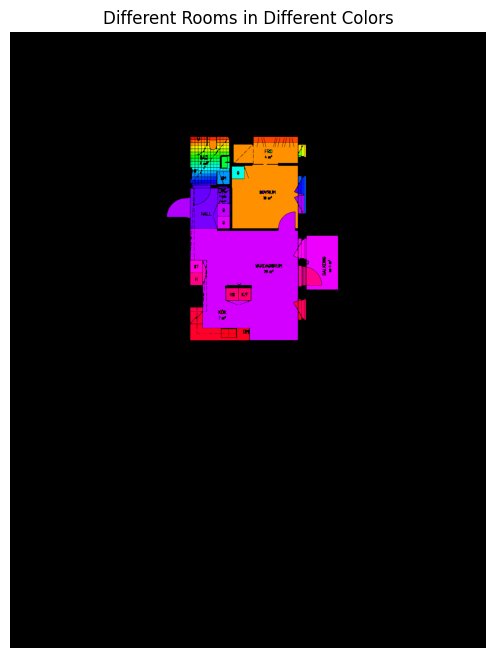

In [ ]:
!apt-get update
!apt-get install poppler-utils
from IPython import get_ipython
from IPython.display import display
# %%
!pip install pdf2image opencv-python matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

# ------------------------------
# 1. Convert PDF to a raster image
# ------------------------------
pdf_path = "1.pdf"  # Your floor-plan PDF
dpi_value = 300      # Increase if you want more detail (300-600 often good)

# Convert the first page of the PDF to an image
# Adding poppler_path to avoid OSError
pages = convert_from_path(pdf_path, dpi=dpi_value)
page_image = pages[0]  # If you have multiple pages, pick the relevant one

# Save to disk as high-resolution JPEG
image_path = "floor_plan.jpg"
page_image.save(image_path, "JPEG")

# ------------------------------
# 2. Load image in grayscale and binarize
# ------------------------------
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Otsu threshold
_, bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Walls typically show up as dark lines (black). If they are black, bin_img will have them as 0.
# Invert so that walls are white:
bin_img = 255 - bin_img

# ------------------------------
# 3. Morphological close (fill small gaps)
# ------------------------------
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=2)

# ------------------------------
# 4. Find external (outer) walls
# ------------------------------
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# If there's more than one outer contour, pick the largest by area
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
else:
    print("No contours found. Check your threshold or morphological steps.")
    largest_contour = None

# Make a mask for the outer walls
external_mask = np.zeros_like(closed)
if largest_contour is not None:
    # Fill the external contour region
    cv2.drawContours(external_mask, [largest_contour], -1, 255, thickness=-1)

# ------------------------------
# 5. Segment different interior spaces
# ------------------------------
# Invert back so that walls are black, empty rooms are white
rooms_for_labeling = 255 - closed

# Restrict labeling to the interior of the building:
# bitwise AND with the external_mask to ignore everything outside.
building_interior = cv2.bitwise_and(rooms_for_labeling, external_mask)
_, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
building_interior = cv2.bitwise_and(building_interior, bin_img)

# Now use connected components to label each enclosed area (each room).
# Each room becomes a unique "label" index.
num_labels, labels = cv2.connectedComponents(building_interior)

print("Total labels found (including background):", num_labels)
# Label 0 = background, 1..(num_labels-1) = different rooms

# ------------------------------
# 6. Color-code each room (for visualization)
# ------------------------------
# Convert label image to HSV color space for easy coloring
label_hue = np.uint8(179 * labels / np.max(labels))  # Hue channel
blank_ch = 255 * np.ones_like(label_hue, dtype=np.uint8)
colored_rooms_hsv = cv2.merge([label_hue, blank_ch, blank_ch])

# Convert HSV to BGR for display
colored_rooms_bgr = cv2.cvtColor(colored_rooms_hsv, cv2.COLOR_HSV2BGR)

# Make the background (label 0) black
colored_rooms_bgr[labels == 0] = (0, 0, 0)

# ------------------------------
# 7. Display the result
# ------------------------------
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(colored_rooms_bgr, cv2.COLOR_BGR2RGB))
plt.title("Different Rooms in Different Colors")
plt.axis("off")
plt.show()


In [ ]:
!pip install pdf2image opencv-python

import cv2
import numpy as np
from pdf2image import convert_from_path

# -------------------------------
# Step 1: Convert PDF to high-DPI image
# -------------------------------
pdf_path = "1.pdf"
dpi_value = 600
pages = convert_from_path(pdf_path, dpi=dpi_value)
pages[0].save("floor_plan.jpg", "JPEG")

# -------------------------------
# Step 2: Read + Threshold + Invert
# -------------------------------
img = cv2.imread("floor_plan.jpg", cv2.IMREAD_GRAYSCALE)
_, bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
bin_img = 255 - bin_img  # walls→white

# -------------------------------
# Step 3: Crop to largest contour (building area)
# -------------------------------
contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
cropped = bin_img[y : y+h, x : x+w].copy()

# -------------------------------
# Step 4: Remove furniture (small objects)
# -------------------------------
# Option A: Morphological opening to remove small white blobs
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
opened = cv2.morphologyEx(cropped, cv2.MORPH_OPEN, kernel_open, iterations=1)

# Option B: Contour area filter (optional or combined)
furniture_removed = opened.copy()
all_cnts, _ = cv2.findContours(furniture_removed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_wall_area = 500  # Must be tuned
for cnt in all_cnts:
    if cv2.contourArea(cnt) < min_wall_area:
        # Fill with black
        cv2.drawContours(furniture_removed, [cnt], -1, 0, -1)

# -------------------------------
# Step 5: Join doors (morphological closing)
# -------------------------------
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
joined = cv2.morphologyEx(furniture_removed, cv2.MORPH_CLOSE, kernel_close, iterations=1)

# -------------------------------
# (Optional) Step 6: External walls or room segmentation
# -------------------------------
# E.g., find outer boundary again in "joined":
contours, _ = cv2.findContours(joined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    building_outline = max(contours, key=cv2.contourArea)
    # do something with 'building_outline'

# If we want to label rooms:
rooms_img = 255 - joined  # make rooms white, walls black
num_labels, labels = cv2.connectedComponents(rooms_img)
print(f"Found {num_labels} labels.")

# Example: Save or show "joined" as your final cleaned floor plan
cv2.imwrite("cleaned_plan.jpg", joined)
print("Saved cleaned floor plan as cleaned_plan.jpg")


Found 13 labels.
Saved cleaned floor plan as cleaned_plan.jpg


In [ ]:
import cv2

# Read the image from disk
img = cv2.imread("floor_plan.jpg")

# img.shape returns (height, width, channels)
height, width = img.shape[:2]

print(f"Image width: {width} pixels")
print(f"Image height: {height} pixels")


Image width: 5100 pixels
Image height: 6601 pixels


In [ ]:
import cv2

# Load your cleaned plan (already processed image)
img = cv2.imread("cleaned_plan.jpg")

# Copy the image so we don't modify the original
annotated = img.copy()

# Get image dimensions
height, width = annotated.shape[:2]

# Grid spacing (in pixels)
step = 50

# Draw horizontal lines + label them
for y in range(0, height, step):
    cv2.line(annotated, (0, y), (width, y), (0, 255, 0), 1)  # draw a horizontal line
    cv2.putText(annotated, f"y={y}", (5, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv2.LINE_AA)

# Draw vertical lines + label them
for x in range(0, width, step):
    cv2.line(annotated, (x, 0), (x, height), (255, 0, 0), 1)  # draw a vertical line
    cv2.putText(annotated, f"x={x}", (x+5, 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1, cv2.LINE_AA)

# Save or show the annotated result
cv2.imwrite("annotated_plan.jpg", annotated)
print("Saved annotated image as annotated_plan.jpg")


Saved annotated image as annotated_plan.jpg


In [ ]:
import cv2

img = cv2.imread("cleaned_plan.jpg")
if img is None:
    raise IOError("Could not read the image.")

height, width = img.shape[:2]
annotated = img.copy()

# Label the top edge with x-coordinates
for x in range(width):
    cv2.putText(annotated, f"{x}", (x, 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)

# Label the left edge with y-coordinates
for y in range(height):
    cv2.putText(annotated, f"{y}", (5, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1, cv2.LINE_AA)

cv2.imwrite("annotated_edge_pixels.jpg", annotated)
print("Saved edge-labeled image as 'annotated_edge_pixels.jpg'")


Saved edge-labeled image as 'annotated_edge_pixels.jpg'


In [ ]:
import cv2
import numpy as np

# Load the cleaned floor plan in grayscale
cleaned_img = cv2.imread("cleaned_plan.jpg", cv2.IMREAD_GRAYSCALE)
if cleaned_img is None:
    raise IOError("Cannot read 'cleaned_plan.jpg'. Check your file path.")

# Convert grayscale to BGR so we can draw colored text
annotated = cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2BGR)

# Find contours of the white areas (the walls)
# CHAIN_APPROX_NONE is used to get *every* contour point, not just endpoints
contours, _ = cv2.findContours(cleaned_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Larger font scale and thickness
font_scale = 1.0
font_thickness = 2
font_face = cv2.FONT_HERSHEY_SIMPLEX
text_color = (0, 0, 255)  # Red

# Loop over each contour
for cnt in contours:
    # cnt is a list of points [ [[x0,y0]], [[x1,y1]], ... ]
    for i, pt in enumerate(cnt):
        x = pt[0][0]
        y = pt[0][1]

        # Put text at each point with bigger font
        cv2.putText(
            annotated,
            f"({x},{y})",
            (x, y),
            font_face,
            font_scale,
            text_color,
            font_thickness,
            cv2.LINE_AA
        )

approx_cnt = cv2.approxPolyDP(cnt, epsilon=2.0, closed=True)
for pt in approx_cnt:
    x, y = pt[0]
    # putText(...) as above

skip_rate = 50  # annotate only every 50th point
for cnt in contours:
    for i, pt in enumerate(cnt):
        if i % skip_rate == 0:  # skip intermediate pixels
            x = pt[0][0]
            y = pt[0][1]
            cv2.putText(
                annotated,
                f"({x},{y})",
                (x, y),
                font_face,
                font_scale,
                text_color,
                font_thickness,
                cv2.LINE_AA
            )



# Save the result
cv2.imwrite("annotated_walls.jpg", annotated)
print("Saved 'annotated_walls.jpg' with pixel coordinates on wall edges.")


Saved 'annotated_walls.jpg' with pixel coordinates on wall edges.


In [ ]:
!apt-get update
!apt-get install poppler-utils

!pip install pdf2image opencv-python

import cv2
import numpy as np
from pdf2image import convert_from_path

# ------------------------------
# 1. Convert the PDF to a high-DPI image
# ------------------------------
pdf_path = "1.pdf"       # Your PDF file name
dpi_value = 600          # Higher DPI => larger, clearer image
pages = convert_from_path(pdf_path, dpi=dpi_value)
pages[0].save("floor_plan.jpg", "JPEG")  # Save first page as JPEG

# ------------------------------
# 2. Load and Binarize (Walls -> White)
# ------------------------------
img_gray = cv2.imread("floor_plan.jpg", cv2.IMREAD_GRAYSCALE)
if img_gray is None:
    raise IOError("Could not read the image. Check PDF conversion or file path.")

# Otsu threshold
_, bin_img = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Invert so walls become white (255)
bin_img = 255 - bin_img

# ------------------------------
# 3. (Optional) Crop to the Main Building Area
# ------------------------------
# Find largest external contour and crop
contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("No external contours found. Check thresholding.")

largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
cropped = bin_img[y : y+h, x : x+w].copy()

# ------------------------------
# 4. Remove Furniture (Small Objects)
# ------------------------------
# (A) Morphological Opening to remove small white blobs
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
opened = cv2.morphologyEx(cropped, cv2.MORPH_OPEN, kernel_open, iterations=1)

# (B) Filter by contour area (optional, can help remove leftover furniture)
furniture_removed = opened.copy()
all_cnts, _ = cv2.findContours(furniture_removed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_wall_area = 500  # Tune as needed
for cnt in all_cnts:
    if cv2.contourArea(cnt) < min_wall_area:
        cv2.drawContours(furniture_removed, [cnt], -1, 0, -1)  # fill with black

# ------------------------------
# 5. Bridge Doors (Morphological Closing)
# ------------------------------
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
cleaned = cv2.morphologyEx(furniture_removed, cv2.MORPH_CLOSE, kernel_close, iterations=1)

# ------------------------------
# 6. Find Wall Contours & Approximate Corners
# ------------------------------
# Convert to color so we can draw colored text on it
annotated = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2BGR)

# Find contours of white walls
wall_contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# We'll approximate each contour's shape so we only get corners
font_scale = 1.0
thickness = 2
color = (0, 0, 255)  # red text
font_face = cv2.FONT_HERSHEY_SIMPLEX

for cnt in wall_contours:
    # Approximate corners to reduce clutter:
    # Epsilon = fraction of the contour perimeter
    epsilon = 0.01 * cv2.arcLength(cnt, closed=True)
    approx = cv2.approxPolyDP(cnt, epsilon, closed=True)
    # Label each corner
    for pt in approx:
        x, y = pt[0]
        cv2.putText(
            annotated,
            f"({x},{y})",
            (x, y),
            font_face,
            font_scale,
            color,
            thickness,
            cv2.LINE_AA
        )

# ------------------------------
# 7. Save the Final Annotated Image
# ------------------------------
final_path = "annotated_corners.jpg"
cv2.imwrite(final_path, annotated)
print(f"Saved the annotated image as '{final_path}'.")

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 128 kB in 1s (94.3 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Don